# Phase 1 

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

### Now load the pickle data into dataframes from the Output folder one directory above

In [5]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


In [6]:
# need to get the file names in the bug report an source code to be the same

# there is no index connection between bugreports index (.name) and the index of the source code
display(all_projects_bugreports.iloc[0].fix)
display(all_projects_source_codes.iloc[217].filename)


array(['org.apache.commons.collections.map.flat3map.java',
       'org.apache.commons.collections.map.testflat3map.java'],
      dtype='<U52')

'\\gitrepo\\src\\java\\org\\apache\\commons\\collections\\list\\transformedlist.java'

## Removing composite varaibles

In [7]:
import re
#remove next line characters:
def remove_new_lines(text):
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

# need to reformat the source code so it can be compared to the bug reports fix array
def format_sc_filename(x):
  
    x = x.split('apache')
    if len(x) != 2:
        x = x[0].split('springframework')
        if len(x) != 2:
            x = x[0].split('wildfly')
            if len(x) == 2:
                x = 'org.wildfly' + x[1]
        else:
             x = 'org.springframework' + x[1]
    else:
         x = 'org.apache' + x[1]
    if len(x) == 1:
        x = x[0]
   
    x = str(x).replace("\\",".")
    return x

# apply the fixes to the filename 
def clean_sc_filepath(df):
    df.filename = df.filename.apply(format_sc_filename)
    return df



In [8]:
#splitting composite words
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)
# STOP_WORDS


### Text cleaning, remove stop words and Stemming

In [10]:
# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# clean up the unprocessed code column
def clean_source_df(df):
    df = clean_new_lines_source_code(df)
    df = clean_composite_source_code(df)
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    df = clean_new_lines_bug_report(df)
    df = clean_composite_bug_report(df)
    df["query"] = df["summary"] + df["description"]
    return df


### Code for generating metrics on similarity scores

In [11]:


# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()
    
    for score in scores:
        indicies = range(len(score))

        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)

        sim_scores.append(sorted_tuple)
    
    return sim_scores

# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:

        fix_sub=list()
        for fix in fixes:

            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)

        fix_list.append(fix_sub)

    # this is a list of the indexes of the file where the fix was located
    return fix_list
        
        
def average_precision(bug,n=10,isCosineSim=True):
#checks precision for the top n values. If n is too large then this score loses meaning
    ap_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        countTrue = 0
        for i in range(len(row[ranked_sim])):
            if i >= n:
                break
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                countTrue+=1
        ap_list.append(countTrue/n)
    return ap_list


def reciprocal_rank(bug,isCosineSim=True):
#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
    rr_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        rr = 0
        for i in range(len(row[ranked_sim])):
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list


### Code for generating similarity score

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def generate_number_terms(arr):
    result = []
    for item in arr:
        result.append( 1 / (1 + np.exp(-1 * item)))
    return result

def custom_min_max(arr):
    min_val = min(arr)
    max_val = max(arr)
    result = []
    for item in arr:
        result.append((item - min_val)/(max_val - min_val))
        
    return result

# calculate the similarity when using revised Vector Space Model
def calculate_similarity_eq7(src_files, src_vect, query, num_terms):

    cosSim = cosine_similarity(query, src_vect).flatten()
    for i in range(len(cosSim)):
        cosSim[i] = cosSim[i] * num_terms[i]
 
    return cosSim

# calculate the similarity when using basic cosine similarity   
def calculate_similarity(src_vect, query):
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim

# fit the vectorizer and transform data
def get_similarity(vect, src_files, src_vect, query_data, num_terms):
    query = vect.transform(query_data)
    similarity = calculate_similarity(src_vect,query)  
    similarity_eq7 = calculate_similarity_eq7(src_files, src_vect, query, num_terms)


    return similarity, similarity_eq7



### Get metrics into the data frames

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# take in the source code df for a project and a single query return scores


def generate_scores_list(source, query):
    scores_list = [] 
    scores_list_eq7 = []
    # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)


    
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
    
    source['unprocessed_code']
    source_lengths = []
    for src in source['unprocessed_code']:
        source_lengths.append(len(src.split()))

    normalized_source_length = custom_min_max(source_lengths)

    num_terms = generate_number_terms(normalized_source_length)

    
    #get the similarity scores for the bug reports    
    for q in query["query"]:
        similarity, similarity_eq7 = get_similarity(vect,source['unprocessed_code'], src_vect, [q], num_terms)
        scores_list.append(similarity)
        scores_list_eq7.append(similarity_eq7)

    return scores_list, scores_list_eq7



def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    i = 0
    for proj in projects:
       
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the scores list
        scores, scores_eq7 = generate_scores_list(src_df, bug_df)

        #append scores list to the bug dataframe
        bug_df["sim_vect"] = scores # the only way that the matrix is related to the src code 
                                    # is through the index.
        bug_df["sim_eq7_vect"] = scores_eq7
        # Rank the source code files and know what file(s) the bug was in
        bug_df["ranked_sim"] = rank_sim_scores(scores)
        bug_df["ranked_eq7_sim"] = rank_sim_scores(scores_eq7)
   
        # get list of where the fixes rank
        bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)
        
        
        # Calculate the AP and RR for Cosine Similarity here
        bug_df["average_precision_1"] = average_precision(bug_df,1,True)
        bug_df["average_precision_5"] = average_precision(bug_df,5,True)
        bug_df["average_precision_10"] = average_precision(bug_df,10,True)

        bug_df["reciprocal_rank"] = reciprocal_rank(bug_df,True)
        
        # Calculate the AP and RR for rVSM here
        bug_df["average_precision_eq7_1"] = average_precision(bug_df,1,False)
        bug_df["average_precision_eq7_5"] = average_precision(bug_df,5,False)
        bug_df["average_precision_eq7_10"] = average_precision(bug_df,10,False)

        bug_df["reciprocal_rank_eq7"] = reciprocal_rank(bug_df,False)



        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [14]:
#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)


In [15]:
bugs, sources = generate_all_scores()

## Calculate and graph MRR and MAP (Overall)

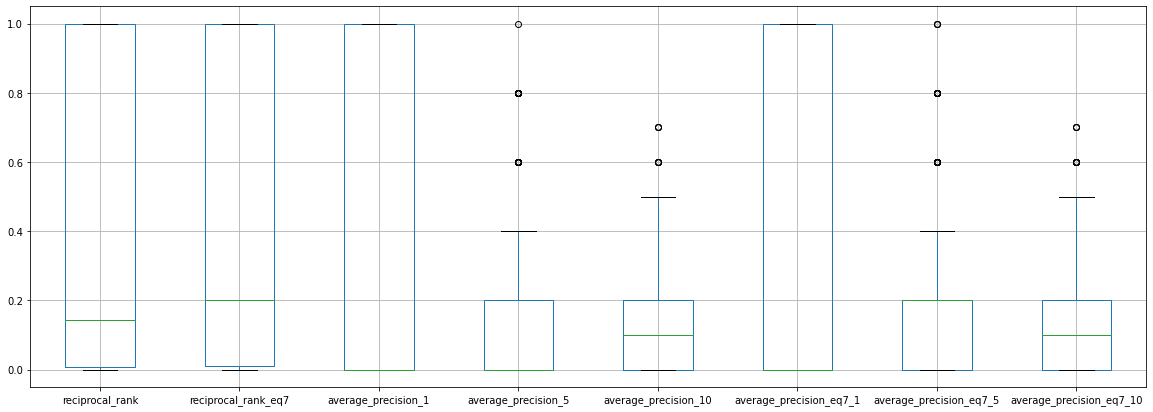

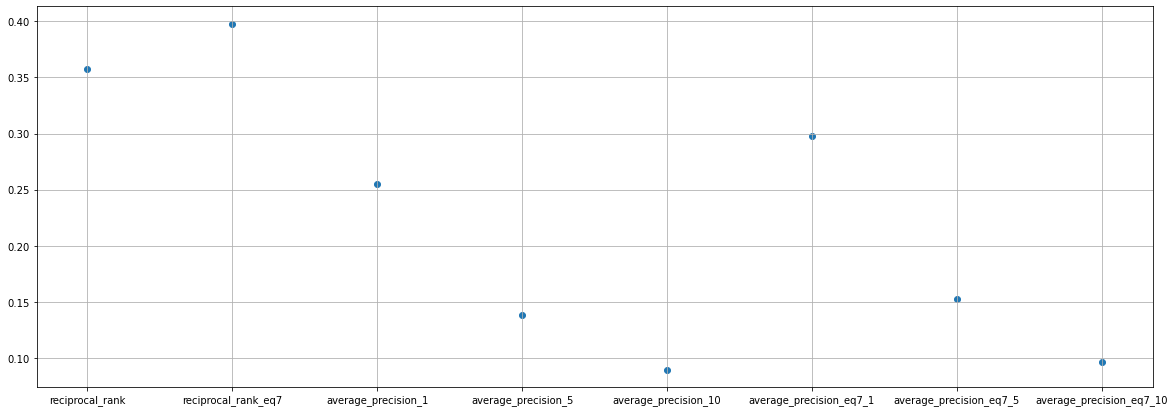

In [16]:
import matplotlib.pyplot as plt
def generate_graphs(bugs):
    important_cols = ["reciprocal_rank","reciprocal_rank_eq7","average_precision_1","average_precision_5","average_precision_10","average_precision_eq7_1","average_precision_eq7_5","average_precision_eq7_10"]
    boxplot = bugs.boxplot(column=important_cols,figsize=(20,7))
    mean_list = list()
    for col in important_cols:
        mean_list.append(bugs[col].mean())
    fig, ax = plt.subplots(figsize=(20,7))
    ax.grid()
    ax.scatter(important_cols,mean_list)
generate_graphs(bugs)

### Generating performance tables

In [17]:
# Creates 2 tables for performance, one for cosine similarity and one for rVSM
def performanceTable(bugs):
    data = []
    data_eq7 = []
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_5","average_precision_10"]
    for proj in projects:
        bug_df = bugs.groupby(bugs.project).get_group(proj).copy()
        perf_list = list()
        perf_list_eq7 = list()
        
        perf_list.append(bug_df['reciprocal_rank'].mean())

        perf_list.append(bug_df['average_precision_10'].mean())
        
        perf_list.append(len(bug_df[(bug_df['average_precision_1']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_1']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_5']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_5']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_10']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_10']!=0)])/(len(bug_df)))
        

        perf_list_eq7.append(bug_df['reciprocal_rank_eq7'].mean())

        perf_list_eq7.append(bug_df['average_precision_eq7_10'].mean())
        
        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_1']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_1']!=0)])/(len(bug_df)))

        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_5']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_5']!=0)])/(len(bug_df)))

        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_10']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_10']!=0)])/(len(bug_df)))
        

        perf_list.append(len(bug_df))
        perf_list_eq7.append(len(bug_df))
        

        data.append(perf_list)
        data_eq7.append(perf_list_eq7)
    df = pd.DataFrame(data,columns=["MRR","MAP (j=10)","Top 1 (Count)","Top 1 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)", "Total Count"])
    df_eq7 = pd.DataFrame(data_eq7 ,columns=["MRR","MAP (j=10)","Top 1 (Count)","Top 1 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)", "Total Count"])
    df['PROJECT'] = projects
    df_eq7['PROJECT'] = projects
    
    df = df.set_index(['PROJECT'])
    df_eq7 = df_eq7.set_index(['PROJECT'])
    
    return df,df_eq7

performance_df,performance_df_eq7 = performanceTable(bugs)


### Performance Per Project using the cosine similarity

In [18]:
performance_df

,MRR,MAP (j=10),Top 1 (Count),Top 1 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Total Count
PROJECT,,,,,,,,,
COLLECTIONS,0.424600,0.101087,32,34.782609,46,50.000000,48,52.173913,92
CONFIGURATION,0.472454,0.121805,48,36.090226,84,63.157895,99,74.436090,133
IO,0.536720,0.105495,42,46.153846,60,65.934066,62,68.131868,91
LANG,0.503349,0.120276,82,37.788018,146,67.281106,152,70.046083,217
DATACMNS,0.443838,0.128481,51,32.278481,97,61.392405,108,68.354430,158
DATAMONGO,0.302186,0.081181,51,18.819188,112,41.328413,143,52.767528,271
DATAREST,0.400030,0.108333,37,28.030303,69,52.272727,81,61.363636,132
LDAP,0.415503,0.116981,14,26.415094,34,64.150943,36,67.924528,53
SEC,0.266030,0.063401,97,17.929760,190,35.120148,237,43.807763,541


### Performance Per Project using rVSM (revised vector space model)

In [19]:
performance_df_eq7

,MRR,MAP (j=10),Top 1 (Count),Top 1 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Total Count
PROJECT,,,,,,,,,
COLLECTIONS,0.433804,0.104348,34,36.956522,48,52.173913,48,52.173913,92
CONFIGURATION,0.513484,0.130075,51,38.345865,89,66.917293,103,77.443609,133
IO,0.585377,0.104396,47,51.648352,62,68.131868,62,68.131868,91
LANG,0.541238,0.120276,95,43.778802,145,66.820276,152,70.046083,217
DATACMNS,0.494659,0.134177,58,36.708861,102,64.556962,111,70.253165,158
DATAMONGO,0.383184,0.099631,73,26.937269,139,51.291513,170,62.730627,271
DATAREST,0.452209,0.121212,45,34.090909,75,56.818182,87,65.909091,132
LDAP,0.487266,0.124528,19,35.849057,35,66.037736,39,73.584906,53
SEC,0.290227,0.067098,110,20.332717,207,38.262477,243,44.916821,541


### Some more Graphs

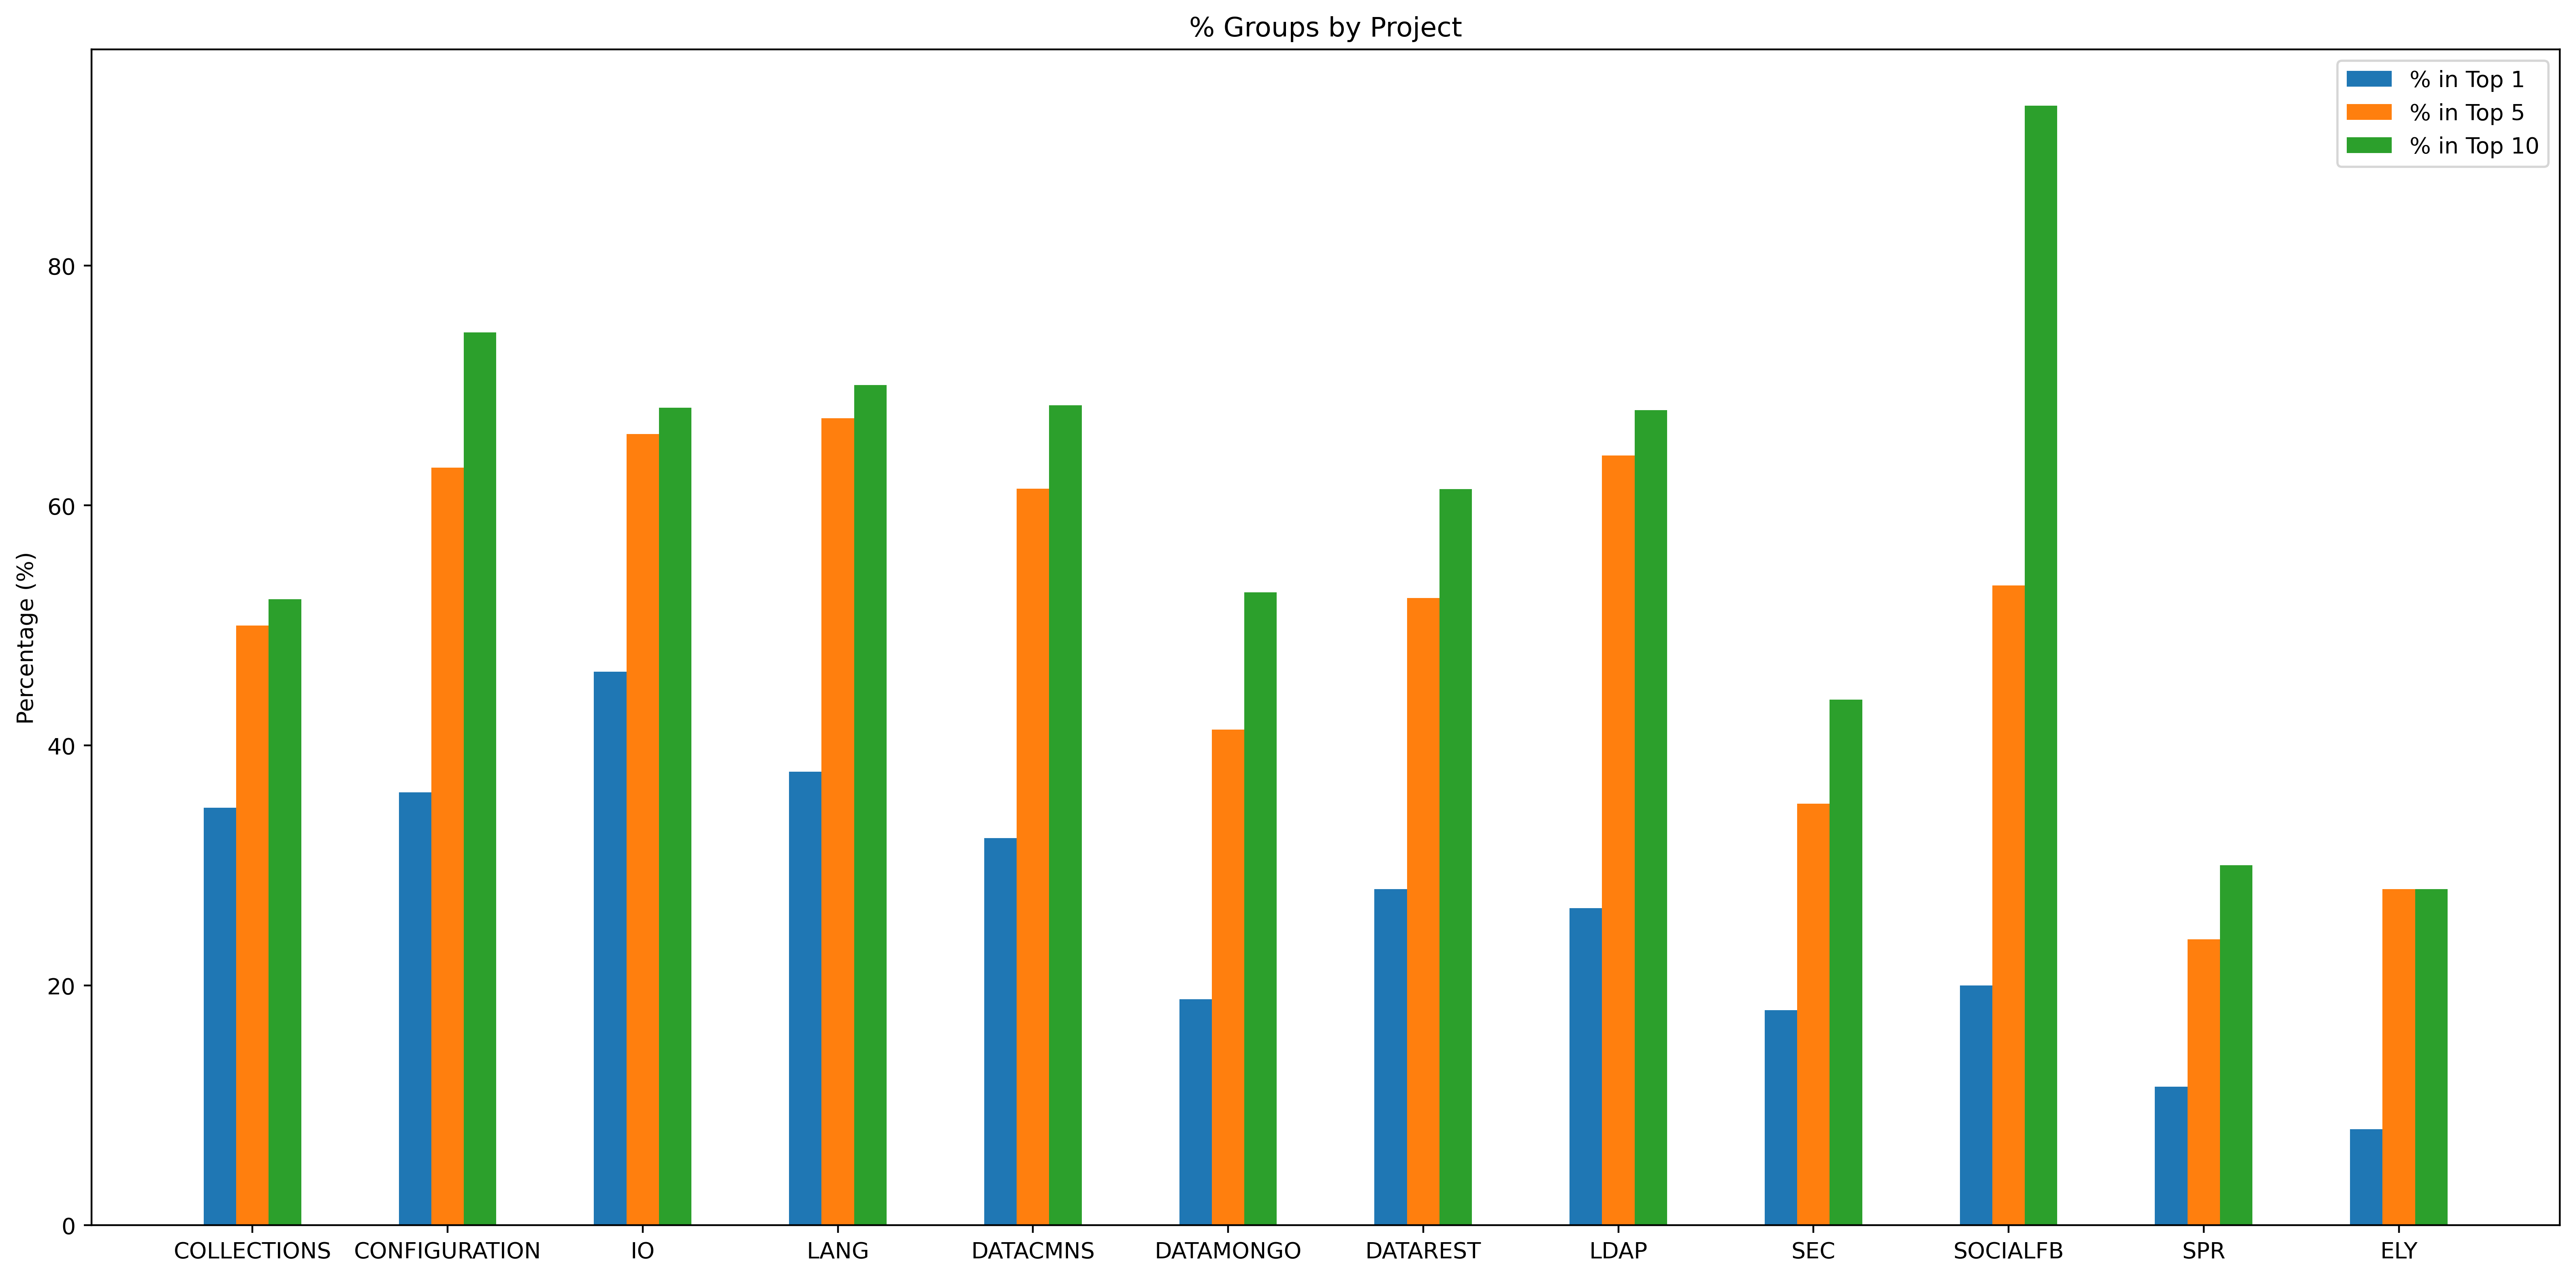

In [20]:
# use performance_df above to generate this bar graph
%matplotlib inline
import matplotlib.pyplot as plt
def generate_bar_chart(df):
    
    bars = ["% in Top 1", "% in Top 5", "% in Top 10"]
    # projects is a list of all the projects
    
    
    width = 0.5
    x = np.arange(len(projects))
    fig, ax = plt.subplots()
    rect1 = ax.bar(x - width*1/3, df["Top 1 (%)"], width/3, label='% in Top 1')
    rect2 = ax.bar(x , df["Top 5 (%)"], width/3, label='% in Top 5')
    rect3 = ax.bar(x + width*1/3, df["Top 10 (%)"], width/3, label='% in Top 10')
    
    ax.set_ylabel("Percentage (%)")
    ax.set_title('% Groups by Project')
    ax.set_xticks(x)
    ax.set_xticklabels(projects)
    ax.legend()
    
#     autolabel(rect1, ax)
#     autolabel(rect2, ax)
#     autolabel(rect3, ax)
    fig.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 400

generate_bar_chart(performance_df)


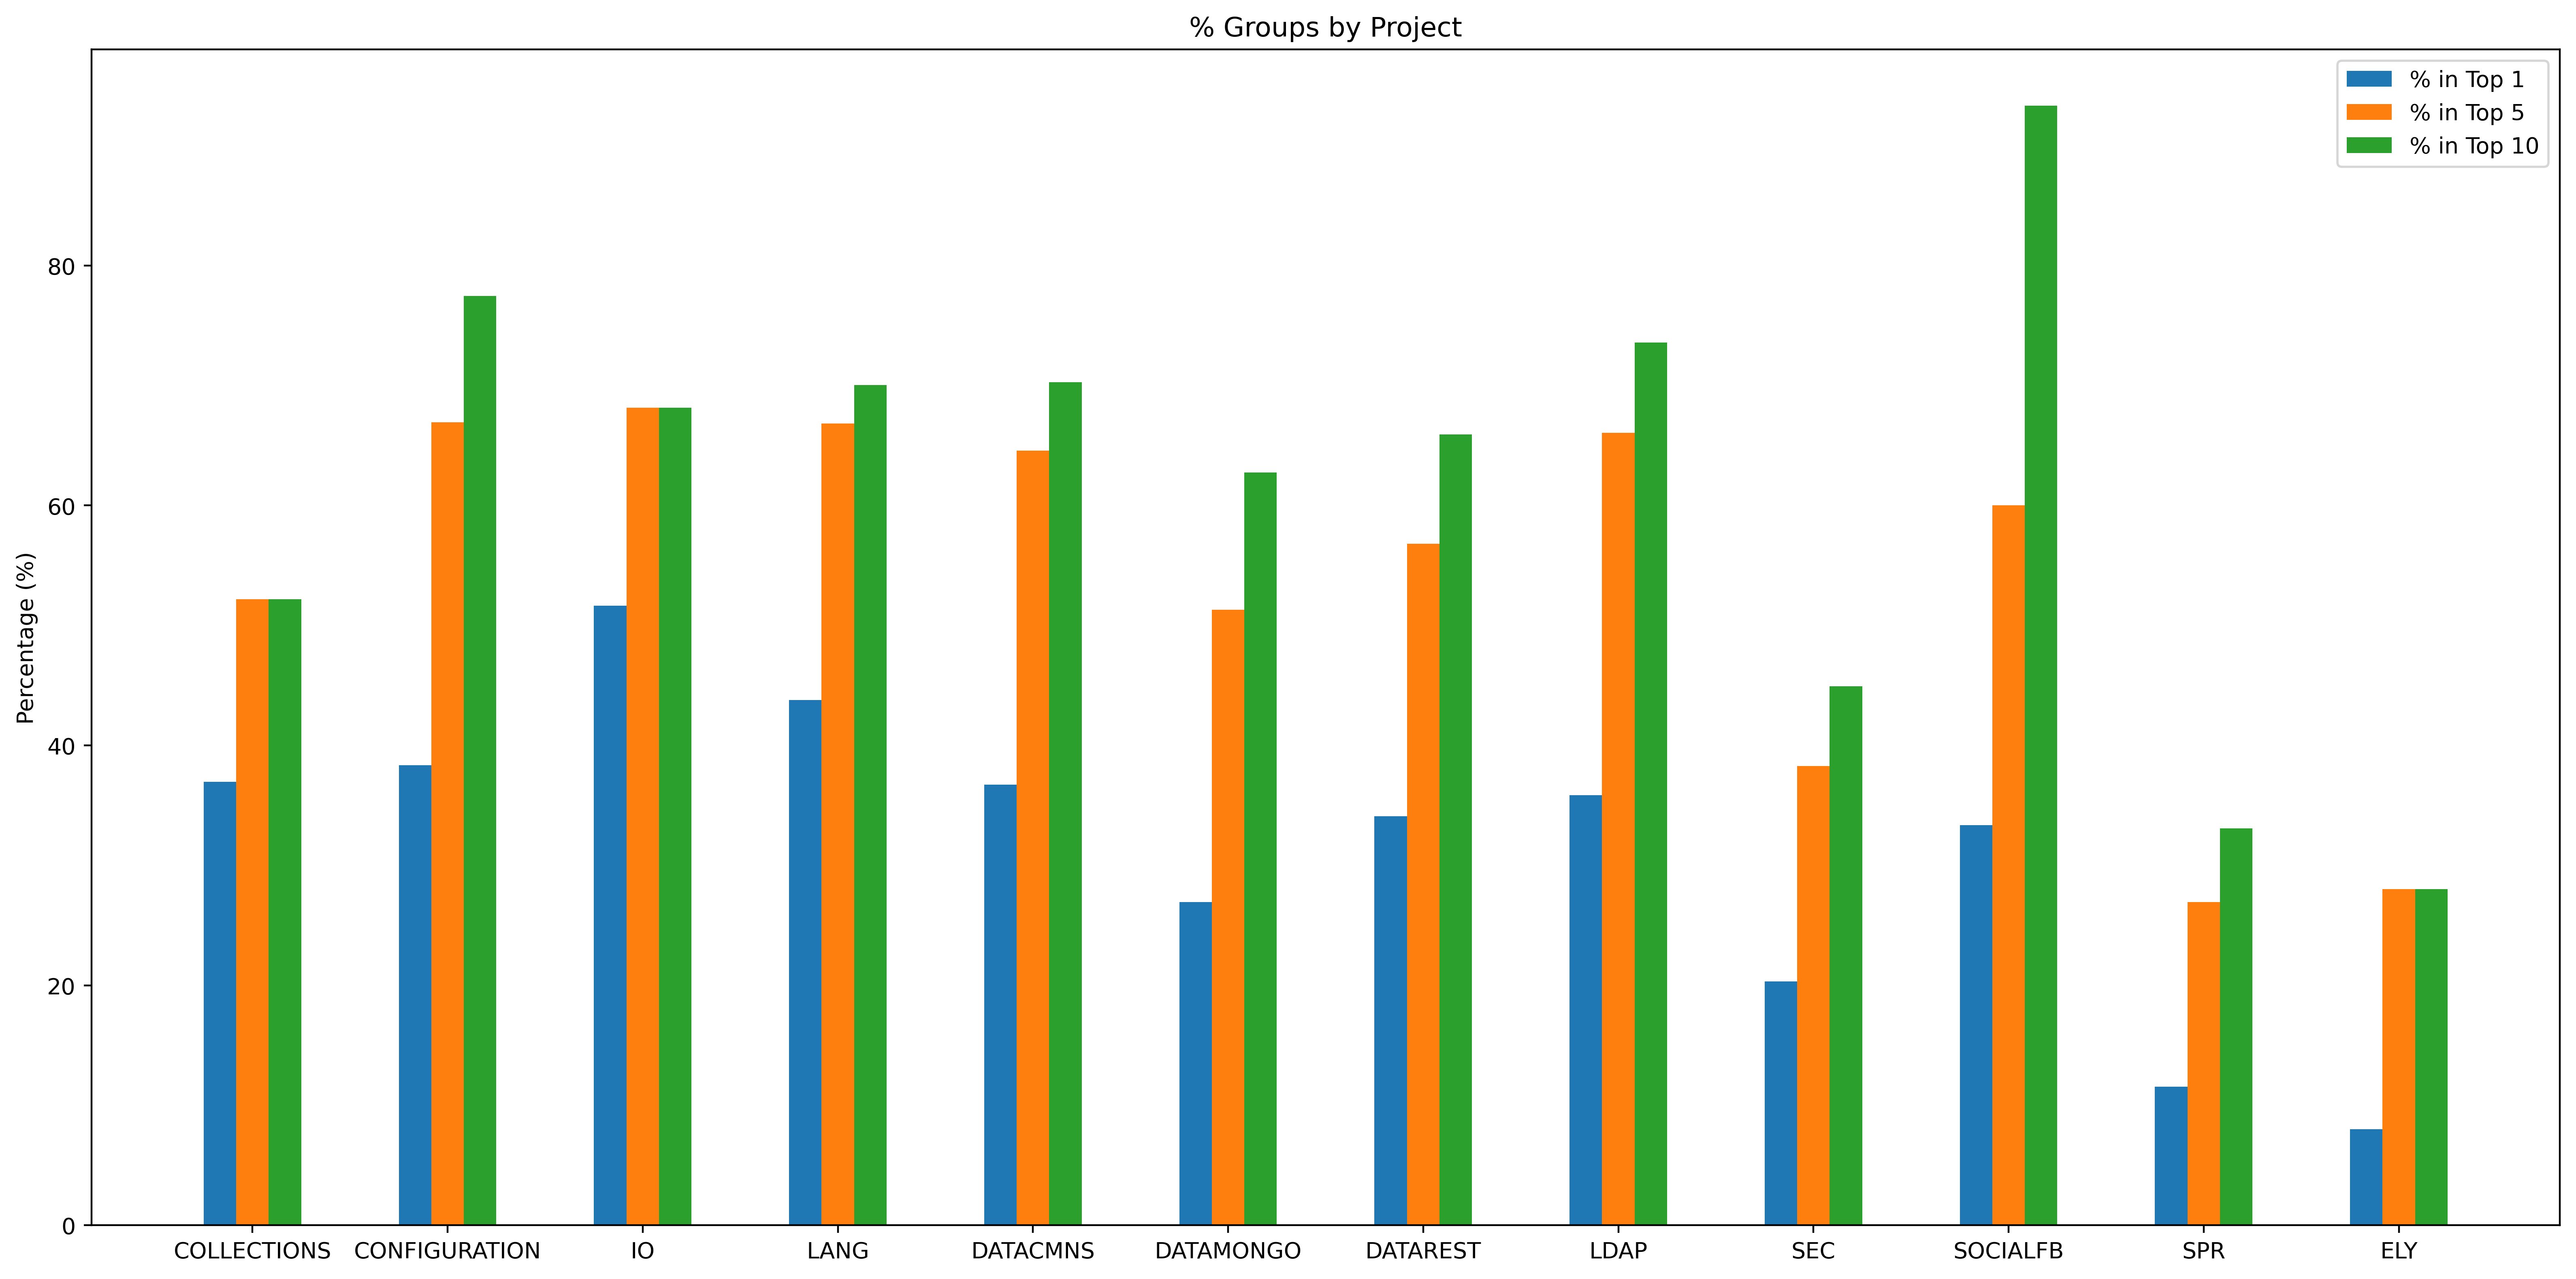

In [21]:
generate_bar_chart(performance_df_eq7)

In [ ]:
def findBugRanks(bug_vectors, source_codes):
    
    similarity_scores = []
    rank_indexs = []
    
    for project, vect, fixes in zip(bug_vectors['project'],bug_vectors['sim_vect'],bug_vectors['fix']): 
        
        code = sc_grouped_df.get_group(project)
        code = code['filename'].to_numpy()  ## find all code files pertaining to the bug reports project 
        
        z = [code for _,code in sorted(zip(vect,code),reverse=True)] ## sort the list of projects based on the similarity scores vector
        sorted_array = np.sort(vect)[::-1]
            
        for fix in fixes:
            try:
                index = z.index(fix)
                score = sorted_array[index]
                similarity_scores.append(score)
                rank_indexs.append(index)
                
                

            except:
                similarity_scores.append(fix)
                rank_indexs.append(-1)
                
    tup = zip(similarity_scores,rank_indexs) # zip the similarity scores along with the rank 
    
    return tup


tup = findBugRanks(bugs, sc_grouped_df)
# tuple(tup)